In [1]:
import os
import sys
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from PIL import Image, ImageStat
import json
import seaborn as sns

sys.path.append('..')
from detection import datasets
from detection.fathomnethelper.json_loader import Taxonomicon

In [2]:
with open('../classes', "r") as f:
    classes = json.load(f)
num_classes = len(classes) + 1

colours = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
colour_mapping = {name: colour for name, colour in zip(classes,colours)}

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"],
    "text.latex.preamble": r"\usepackage{amsmath} \usepackage{xfrac}",
    })


### First, we read bounding box data

In [3]:
ann_paths = os.listdir(os.path.join('..', 'data', 'train', 'annotations'))
tax = Taxonomicon()
subtrees_of_each_class = {
    name: set.union(*list(map(set, [tax.get_subtree_nodes(concept) for concept in families]))) 
    for name, families in classes.items()
}
class_mapping = {}
for clss in classes:
    for val in subtrees_of_each_class[clss]:
        class_mapping[val] = clss

annotations = {concept: [] for concept in classes}

for ann in ann_paths:
    ann_tree = ET.parse(os.path.join('..', 'data', 'train', 'annotations', ann))
    tree_root = ann_tree.getroot()
    w = int(tree_root.find('size/width').text)
    h = int(tree_root.find('size/height').text)
    for box in tree_root.iter('object'):
        name = box.find('name').text
        if name in class_mapping:
            clss = class_mapping[name]
            xmin = int(box.find('bndbox/xmin').text)
            ymin = int(box.find('bndbox/ymin').text)
            xmax = int(box.find('bndbox/xmax').text)
            ymax = int(box.find('bndbox/ymax').text)
            annotations[clss].append((os.path.splitext(ann)[0] + '.png', (w,h), (xmin, ymin, xmax, ymax)))

### Here we plot histograms of aspect ratios of each class

In [4]:
aspect_ratios = {
    clss: [(xmax-xmin)/(ymax-ymin) 
                   for (impath, (w,h), (xmin,ymin,xmax,ymax)) in annotations[clss]] 
    for clss in classes
}

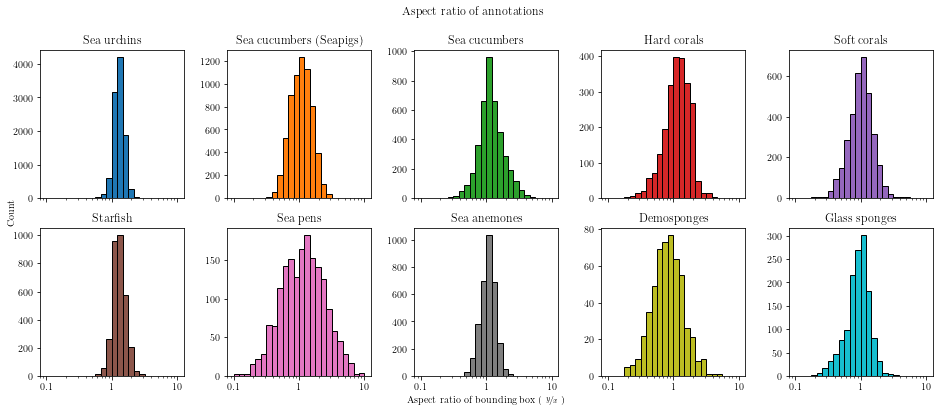

In [86]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(16,6), sharex=True)

logbins = np.geomspace(0.1, 10, 25)

for i, name in enumerate(classes):
    ax = axes[i//5][i%5]
    ax.set_title(name)
    ax.hist(aspect_ratios[name], bins=logbins, color=colour_mapping[name], edgecolor='k')
    ax.set_xscale('log')
    
    ax.set_xscale('log')
    x_major = ticker.LogLocator(base = 10.0, numticks = 6)
    ax.xaxis.set_major_locator(x_major)
    x_minor = ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10)
    ax.xaxis.set_minor_locator(x_minor)
    ax.xaxis.set_minor_formatter(ticker.NullFormatter())
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.2g}'))


plt.subplots_adjust(wspace=.3, hspace=.2)

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel(r"Aspect ratio of bounding box ( $ \sfrac{y}{x} $ )")
plt.ylabel("Count")
plt.suptitle("Aspect ratio of annotations")
plt.savefig('aspect_ratio.png', facecolor='white', transparent=False, dpi=200)

### Area histograms

In [122]:
areas = {
    clss: [np.sqrt((xmax-xmin)*(ymax-ymin)) 
                   for (impath, (w,h), (xmin,ymin,xmax,ymax)) in annotations[clss]] 
    for clss in classes
}

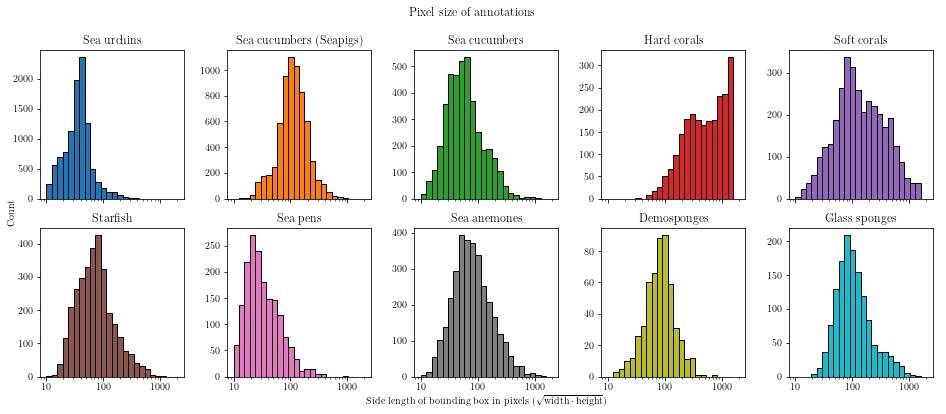

In [123]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(16,6), sharex=True)

logbins = np.geomspace(10, 2000, 25)

for i, name in enumerate(classes):
    ax = axes[i//5][i%5]
    ax.set_title(name)
    ax.hist(areas[name], bins=logbins, color=colour_mapping[name], edgecolor='k')
    ax.set_xscale('log')
    #ax.set_yscale('log')
    
    x_major = ticker.LogLocator(base = 10.0, numticks = 3)
    ax.xaxis.set_major_locator(x_major)
    x_minor = ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10)
    ax.xaxis.set_minor_locator(x_minor)
    ax.xaxis.set_minor_formatter(ticker.NullFormatter())
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

plt.subplots_adjust(wspace=.3, hspace=.2)
    
# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel(r"Side length of bounding box in pixels ($\sqrt{\text{width}\cdot \text{height}}$)")
plt.ylabel("Count")
plt.suptitle("Pixel size of annotations")
plt.savefig('pixel_sizes.png', facecolor='white', transparent=False, dpi=200)

### Relative areas

In [9]:
rel_areas = {
    clss: [(xmax-xmin)*(ymax-ymin) / (w*h) 
                   for (impath, (w,h), (xmin,ymin,xmax,ymax)) in annotations[clss]] 
    for clss in classes
}

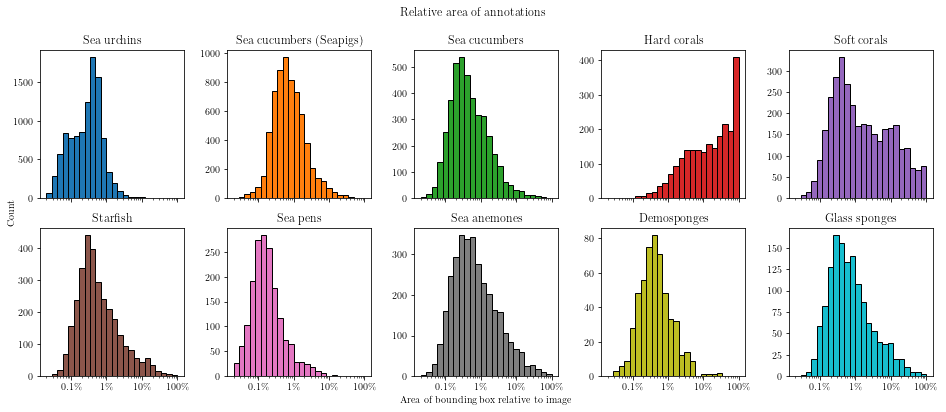

In [131]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(16,6), sharex=True)

logbins = np.geomspace(0.0002, 1, 25)

class PercentFormatter:
    def format(self, x, pos):
        if x < 0.01:
            return '{:.1g}\%'.format(100 * x, pos)
        return '{}\%'.format(int(100 * x), pos)

for i, name in enumerate(classes):
    ax = axes[i//5][i%5]
    ax.set_title(name)
    ax.hist(rel_areas[name], bins=logbins, color=colour_mapping[name], edgecolor='k')

    ax.set_xscale('log')
    x_major = ticker.LogLocator(base = 10.0, numticks = 5)
    ax.xaxis.set_major_locator(x_major)
    x_minor = ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10)
    ax.xaxis.set_minor_locator(x_minor)
    ax.xaxis.set_minor_formatter(ticker.NullFormatter())
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter(PercentFormatter()))
    
plt.subplots_adjust(wspace=.3, hspace=.2)
# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Area of bounding box relative to image")
plt.ylabel("Count")
plt.suptitle('Relative area of annotations')
plt.savefig('relative_area.png', facecolor='white', transparent=False, dpi=200)

In [14]:
rel_areas_tot = [val for li in rel_areas.values() for val in li]

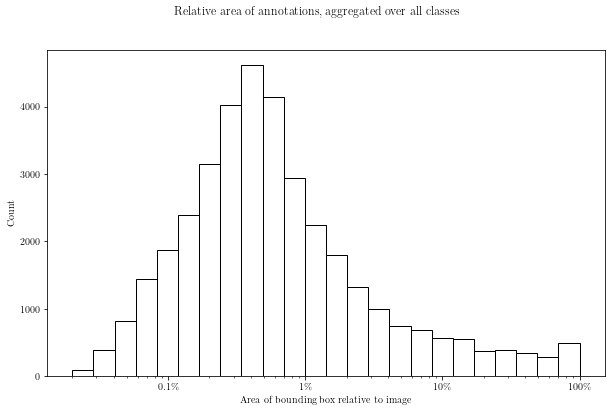

In [132]:
fig, ax = plt.subplots(figsize=(10,6))

logbins = np.geomspace(0.0002, 1, 25)

ax.set_title('')
ax.set_ylabel('Count')
ax.set_xlabel('Area of bounding box relative to image')
ax.hist(rel_areas_tot, bins=logbins, edgecolor='k', color='w')

ax.set_xscale('log')
x_major = ticker.LogLocator(base = 10.0, numticks = 6)
ax.xaxis.set_major_locator(x_major)
x_minor = ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10)
ax.xaxis.set_minor_locator(x_minor)
ax.xaxis.set_minor_formatter(ticker.NullFormatter())
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter(PercentFormatter()))

plt.suptitle('Relative area of annotations, aggregated over all classes')
plt.savefig('rel_area_combined.png', facecolor='white', transparent=False, dpi=300)

In [9]:
x = []
y = []
c = []
ims = []
for i, cls in enumerate(classes):
    for impath, (w,h), (xmin,ymin,xmax,ymax) in annotations[cls]:
        x.append((xmax - xmin) * (ymax - ymin))
        y.append(w * h)
        c.append(i)
        ims.append(impath)
print(len(set(ims)))

14939


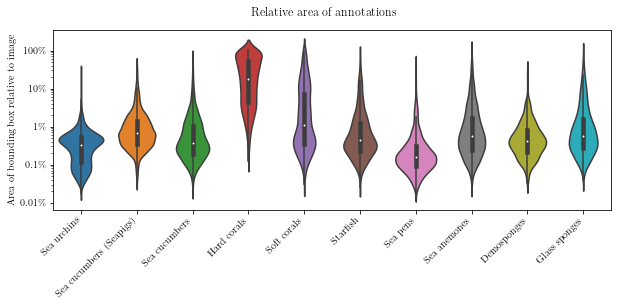

In [146]:
fig, ax = plt.subplots(figsize=(10,3.3))

data = [np.log10(np.array(rel_areas[cls])) for cls in classes]
sns.violinplot(data=data, ax=ax)
ax.yaxis.set_ticks([np.log10(x) for p in range(-4,0) for x in np.linspace(10**p, 10**(p+1), 10)], minor=True)


y_major = ticker.FixedLocator(locs=[-4,-3,-2,-1,0])
ax.yaxis.set_major_locator(y_major)
ax.set_yticklabels(["0.01\%","0.1\%","1\%","10\%","100\%"])

ax.set_xticklabels(classes, rotation=45, ha='right')
ax.set_ylabel('Area of bounding box relative to image')
plt.suptitle('Relative area of annotations')
plt.savefig('rel_area_violin.png', facecolor='white', transparent=False, dpi=300)